<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define Functions</a></span></li><li><span><a href="#Pre-processing-the-Data" data-toc-modified-id="Pre-processing-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-processing the Data</a></span><ul class="toc-item"><li><span><a href="#LDA-Model" data-toc-modified-id="LDA-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LDA Model</a></span><ul class="toc-item"><li><span><a href="#Load-LDA-Model" data-toc-modified-id="Load-LDA-Model-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Load LDA Model</a></span></li><li><span><a href="#Run-LDA-Model" data-toc-modified-id="Run-LDA-Model-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Run LDA Model</a></span></li><li><span><a href="#Save-LDA-Model" data-toc-modified-id="Save-LDA-Model-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Save LDA Model</a></span></li><li><span><a href="#Define-a-useful-function" data-toc-modified-id="Define-a-useful-function-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Define a useful function</a></span></li><li><span><a href="#Define-main-functions-for-retrieving-topics-from-reviews" data-toc-modified-id="Define-main-functions-for-retrieving-topics-from-reviews-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Define main functions for retrieving topics from reviews</a></span></li></ul></li></ul></li></ul></div>

In [1]:
#Importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
from nltk import FreqDist

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, phrases
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import seaborn as sns
import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [2]:
PROJ_ROOT = '/Users/dmitriykats/Documents/SpringBoard/Springboard/Capstone2/true_review/'

In [3]:
#import local python functions
import sys
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

#import methods
from features.nlp_preprocess import freq_words

In [4]:
path = '../data/'
models = '../models/'

In [5]:
#we've already pre-processed the data so we can import it
df_scott = pd.read_csv(f'{path}/interim/sdl_data.csv', parse_dates=['date'])
df_scott = df_scott.drop(columns='Unnamed: 0')
df_scott.head()

,user_id,business_id,rev_stars,date,text,useful,funny,cool,name,neighborhood,...,longitude,bus_stars,review_count,is_open,categories,weekday,text length,year,split_categories,string_categories
0,771OWzbzelsEeSlx8QsfsQ,orMlHMLyHSldYgzfFTaeoA,4,2011-07-15,I really like this place. I have been numerous...,1,0,0,"""Eddie's House""",NaN,...,-111.929214,3.5,317,0,Seafood;American (New);Restaurants,4,509,2011,"['Seafood', 'American (New)']",Seafood American (New)
1,Pj9YpaP0T7A_5S_PT8IpNg,OtVNeY6IfUh3CIOCzmfg3A,5,2012-08-15,Greasewood Flat is hugely popular with winter ...,4,3,2,"""Greasewood Flat""",NaN,...,-111.846131,4.0,123,0,Burgers;Restaurants;Hot Dogs;Nightlife;Bars,2,1463,2012,"['Burgers', 'Hot Dogs', 'Bars']",Burgers Hot Dogs Bars
2,7M1zIE6OzpySDlqLU6MnEg,is2RonWgyENNKOprcXQK6w,5,2011-11-04,3 times in 2 weeks should tell you thy this pl...,3,2,2,"""Osha Thai Cafe""",NaN,...,-111.834405,4.0,114,1,Salad;Restaurants;Soup;Thai,4,394,2011,"['Salad', 'Soup', 'Thai']",Salad Soup Thai
3,9uE0smG2bwgkI95RPj0lPQ,sKrlmbrZWCyLIgiMihCPqw,5,2015-11-16,I still love Hula's! Came here for a celebrat...,1,0,1,"""Hula's Modern Tiki Scottsdale""",NaN,...,-111.925625,4.0,509,1,Hawaiian;Restaurants;Pan Asian,0,560,2015,"['Hawaiian', 'Pan Asian']",Hawaiian Pan Asian
4,iN7T3vQoC3v_MPs2TzH5Zw,ghRXtBi--SW8uWQhrijBjw,4,2013-11-25,"In the daytime, Old Town is a cool destination...",3,0,3,"""Old Town Scottsdale""",NaN,...,-111.922440,4.0,106,1,Shopping Centers;Transportation;Public Service...,0,1027,2013,"['Shopping Centers', 'Transportation', 'Public...",Shopping Centers Transportation Public Service...


In [6]:
#looking at the first review
df_scott.text.iloc[0]

'I really like this place. I have been numerous amt of times and I keep wanting more. The friendly bartenders, the exciting chef  (Eddie). The best part of this place besides the good food and comfort level is their ALL Night Happy Hour. Yes All night $5 dollar specialty cocktails like an espresso martini or wines of the day. All first courses (apps) are half off too. The apps includes, lambchops ($19), Tuna tartar with wonton chips ($9) and so much more. Great s[ot and yearning for more since last night.'

# Define Functions

In [7]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [8]:
from nltk.corpus import stopwords
my_stops = ['The', 'the', 'www', 'yelp', 'scottsdale', 
            'http', 'com', 'yelp', 'http_www', 'food', 
            'restaurant', 'place', 'good', 'great']
stop_words = stopwords.words('english')
for word in my_stops:
    stop_words.append(word)
# function to remove stopwords

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']): # filter noun, verb, adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
            
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

# Pre-processing the Data

In [10]:
#start pre-processing the reviews from the Scottsdale dataframe
reviews = df_scott.text

In [11]:
# remove unwanted characters, numbers and symbols
df_scott['processed'] = df_scott['text'].str.replace("[^a-zA-Z#]", " ")

In [12]:
df_scott.processed.iloc[0]

'I really like this place  I have been numerous amt of times and I keep wanting more  The friendly bartenders  the exciting chef   Eddie   The best part of this place besides the good food and comfort level is their ALL Night Happy Hour  Yes All night    dollar specialty cocktails like an espresso martini or wines of the day  All first courses  apps  are half off too  The apps includes  lambchops        Tuna tartar with wonton chips      and so much more  Great s ot and yearning for more since last night '

In [13]:
# remove short words (length < 3)
df_scott['processed'] = df_scott['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# make entire processed lowercase
reviews = [r.lower() for r in reviews]
# remove stopwords from the processed
reviews = [remove_stopwords(r.split()) for r in df_scott['processed']]

In [14]:
df_scott.processed.iloc[0]

'really like this place have been numerous amt times and keep wanting more The friendly bartenders the exciting chef Eddie The best part this place besides the good food and comfort level their ALL Night Happy Hour Yes All night dollar specialty cocktails like espresso martini wines the day All first courses apps are half off too The apps includes lambchops Tuna tartar with wonton chips and much more Great and yearning for more since last night'

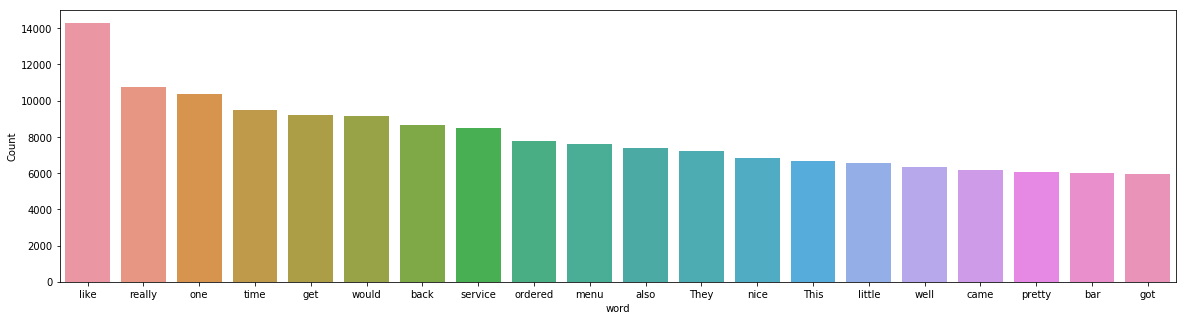

In [15]:
freq_words(reviews, 20)

Next we'll tokenize the reviews and create bigrams and trigrams.

In [16]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_2 = lemmatization(tokenized_reviews)

In [17]:
bigrams = phrases.Phrases(tokenized_reviews, min_count=3, threshold=10)
reviews_2 = [bigrams[line] for line in reviews_2]

In [18]:
trigrams = phrases.Phrases(reviews_2, min_count=3, threshold=10)
reviews_2 = [trigrams[line] for line in reviews_2]

In [19]:
#let's save our bigram and trigram model for later use in the modeling section
import os
import codecs
intermediate_directory = os.path.join(models, 'interim')

In [20]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')

In [21]:
bigrams.save(os.path.join(bigram_model_filepath, 'bigram_model'))
trigrams.save(os.path.join(trigram_model_filepath, 'trigram_model'))

In [ ]:
# load the finished model from disk
#bigram_model = Phrases.load(bigram_model_filepath)

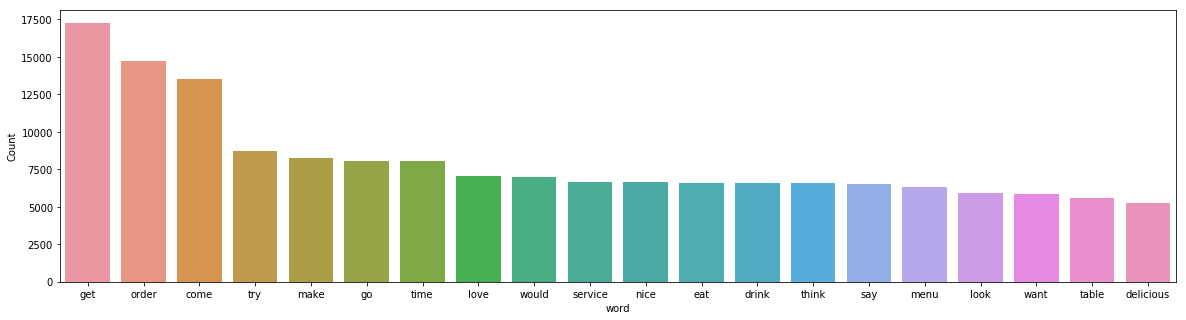

In [22]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df_scott['reviews'] = reviews_3
freq_words(df_scott['reviews'], 20)

In [23]:
print(df_scott.reviews.iloc[0])
print(f'Text length: {len(df_scott.reviews.iloc[0])}')

numerous amt time keep want friendly bartender exciting chef good_part comfort level night dollar specialty_cocktail espresso_martini wine day first_course app half app include lambchop tartar wonton_chip much great yearning last_night
Text length: 235


## LDA Model

In [24]:
dictionary = Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [25]:
dictionary_filepath = os.path.join(intermediate_directory, 'dictionary_all')

In [26]:
dictionary.save(os.path.join(dictionary_filepath, 'dictionary'))
#doc_term_matrix.save(os.path.join(dictionary_filepath, 'doc_matrix'))

### Load LDA Model

In [28]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_scott_model")
#lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
lda_model = LdaModel.load(temp_file)

Warning: next cell is time intensive, running for 25mins on an average notebook.

### Run LDA Model

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                num_topics=50, 
                random_state=42,
                chunksize=1000, 
                passes=100)

### Save LDA Model

In [ ]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_scott_model")
lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
#lda_model = LdaModel.load(temp_file)

### Define a useful function

In [29]:
def explore_topic(topic_number, topn=20):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """   
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
    for term, frequency in lda_model.show_topic(topic_number, topn=20):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [30]:
explore_topic(27)

term                 frequency

think                0.030
get                  0.028
bad                  0.022
price                0.021
go                   0.018
time                 0.017
say                  0.017
would                0.017
seem                 0.016
thing                0.016
well                 0.014
service              0.014
try                  0.014
eat                  0.013
come                 0.012
decent               0.011
feel                 0.010
place                0.010
cheap                0.010
average              0.009


Create a manual topic_name dictionary

In [31]:
topic_names = {0: u'service',
               1: u'sports bar',
               2: u'vegetarian, cafe',
               3: u'kid friendly',
               4: u'location',
               5: u'secret',
               6: u'sides, vietnamese',
               7: u'greek, hummus',
               8: u'food dishes',
               9: u'table, sit',
               10: u'golf',
               11: u'pizza, italian',
               12: u'dinner',
               13: u'big menue',
               14: u'sushi',
               15: u'bbq',
               16: u'dessert',
               17: u'french',
               18: u'healthy, salad',
               19: u'asian',
               20: u'quality, service',
               21: u'mall, food court',
               22: u'breakfast',
               23: u'burger & fries',
               24: u'wings, bbq',
               25: u'hotel',
               26: u'sushi',
               27: u'cheap, good, service',
               28: u'movie theater',
               29: u'comfort food',
               30: u'mexican',
               31: u'bars',
               32: u'italian',
               33: u'italian',
               34: u'coffee shop',
               35: u'lunch, sandwich',
               36: u'buffet',
               37: u'foreign, authentic',
               38: u'southern',
               39: u'service and seating',
               40: u'steak, dinner',
               41: u'happy hour, drinks',
               42: u'customer service',
               43: u'hard to find',
               44: u'tapas, appetizers',
               45: u'healthy',
               46: u'chinese',
               47: u'lunch',
               48: u'beer, wine, drinks',
               49: u'service'}

### Define main functions for retrieving topics from reviews

In [32]:
def get_sample_review(review_number):
    """
    retrieve a particular review index
    from the reviews file and return it
    """
    return df_scott.text.iloc[review_number]

In [33]:
def lda_description(review_text, min_topic_freq=0.05):
    """
    accept the original text of a review and (1) parse it with spaCy,
    (2) apply text pre-proccessing steps, (3) create a bag-of-words
    representation, (4) create an LDA representation, and
    (5) print a sorted list of the top topics in the LDA representation
    """
    # remove unwanted characters, numbers and symbols
    processed_review = review_text.replace("[^a-zA-Z#]", " ")
    # remove short words (length < 3)
    processed_review = ' '.join([w for w in processed_review.split() if len(w)>2])
    # make entire processed lowercase
    sample_review = processed_review.lower()
    
    # remove stopwords from the processed
    sample_review = [word for word in sample_review.split() if word not in stop_words]
    tokenized_sample = sample_review
    tags=['NOUN', 'ADJ', 'VERB']
    sample_lemma = [token.lemma_ for token in nlp(' '.join(tokenized_sample)) if token.pos_ in tags]
    
    bigram_reviews_2 = bigrams[sample_lemma]
    
    trigram_reviews_2 = trigrams[bigram_reviews_2]
    
    # create a bag-of-words representation
    review_bow = dictionary.doc2bow(trigram_reviews_2)
    
    # create an LDA representation
    review_lda = lda_model[review_bow]
    sorted_review_lda = sorted(review_lda, key=lambda tub: tub[1], reverse=True)
    print(sorted_review_lda)
    for topic_num, freq in sorted_review_lda:
        if freq < min_topic_freq:
            break
        print('{:25} {}'.format(topic_names[topic_num], format(freq, '.2f')))   

In [34]:
sample_review = get_sample_review(0)
print(sample_review)

I really like this place. I have been numerous amt of times and I keep wanting more. The friendly bartenders, the exciting chef  (Eddie). The best part of this place besides the good food and comfort level is their ALL Night Happy Hour. Yes All night $5 dollar specialty cocktails like an espresso martini or wines of the day. All first courses (apps) are half off too. The apps includes, lambchops ($19), Tuna tartar with wonton chips ($9) and so much more. Great s[ot and yearning for more since last night.


In [35]:
lda_description(sample_review)

[(12, 0.21444157), (41, 0.17710838), (27, 0.17510842), (47, 0.16282788), (36, 0.11052829), (45, 0.061247505), (40, 0.038852606), (6, 0.03437488)]
dinner                    0.21
happy hour, drinks        0.18
cheap, good, service      0.18
lunch                     0.16
buffet                    0.11
healthy                   0.06


In [36]:
### libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.196558  0.052568       1        1  3.905494
1     -0.131850  0.093025       2        1  0.733581
2     -0.209794  0.024165       3        1  0.366875
3     -0.100481  0.068054       4        1  0.846939
4      0.212048  0.062543       5        1  3.544544
5     -0.173758  0.050983       6        1  0.514702
6     -0.001922  0.010968       7        1  1.062290
7     -0.206874 -0.004774       8        1  0.358260
8      0.199900 -0.145111       9        1  7.429561
9      0.188776  0.179108      10        1  4.744829
10    -0.172165  0.043129      11        1  0.599795
11     0.032988 -0.152088      12        1  0.988425
12     0.134607  0.013190      13        1  2.831874
13    -0.133817  0.039951      14        1  0.641378
14     0.025641  0.123016      15        1  1.469245
15    -0.203460  0.038421      16        1  0.353030
16    -0.094041 -0.105800      17        1  1.092025
17    -0.156539 -0.011884      18        1  0.640001
18     0.072578 -0.162721      19        1  1.779616
19    -0.179498  0.014734      20        1  0.514276
20     0.283180  0.001383      21        1  6.366318
21    -0.209955  0.007152      22        1  0.307530
22     0.127319 -0.091938      23        1  2.049970
23     0.143618 -0.171623      24        1  2.670625
24    -0.154777 -0.066731      25        1  0.548057
25     0.102759  0.141587      26        1  2.484398
26    -0.059605 -0.067754      27        1  0.701252
27     0.232251  0.102502      28        1  5.155547
28    -0.030107  0.113179      29        1  0.938604
29    -0.199861  0.022445      30        1  0.432984
30     0.120669 -0.186251      31        1  2.093943
31     0.201497  0.166569      32        1  4.193857
32    -0.162093 -0.061912      33        1  0.472446
33    -0.182995  0.018963      34        1  0.503852
34     0.050633 -0.080501      35        1  1.230259
35    -0.080396 -0.110790      36        1  0.866122
36     0.026175  0.020443      37        1  1.423365
37    -0.171461 -0.015450      38        1  0.533751
38    -0.159870 -0.022023      39        1  0.560504
39     0.057691  0.172655      40        1  1.600293
40     0.215638 -0.111781      41        1  4.418642
41     0.132686  0.053778      42        1  2.459385
42     0.268043  0.111162      43        1  9.712882
43    -0.008269  0.133120      44        1  1.301919
44     0.001586 -0.211698      45        1  1.177430
45    -0.153226  0.002497      46        1  0.605548
46     0.162798 -0.204873      47        1  2.655427
47    -0.150911  0.055072      48        1  0.644565
48     0.072994 -0.000135      49        1  1.732123
49     0.225093  0.049478      50        1  5.741655, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
457   Default   5014.000000       salad   5014.000000  30.0000  30.0000
401   Default   3334.000000       lunch   3334.000000  29.0000  29.0000
655   Default   3576.000000       pizza   3576.000000  28.0000  28.0000
217   Default   3117.000000    sandwich   3117.000000  27.0000  27.0000
110   Default  14691.000000       order  14691.000000  26.0000  26.0000
127   Default   6525.000000       drink   6525.000000  25.0000  25.0000
37    Default   3194.000000      burger   3194.000000  24.0000  24.0000
846   Default   2393.000000        star   2393.000000  23.0000  23.0000
103   Default   3347.000000     chicken   3347.000000  22.0000  22.0000
209   Default   3498.000000      flavor   3498.000000  21.0000  21.0000
35    Default   2262.000000        beer   2262.000000  20.0000  20.0000
634   Default   3105.000000         fry   3105.000000  19.0000  19.0000
474   Default   2500.000000   breakfast   2500.000000  18.0000  18.0000
382   Default   2828.000000    location   2828.000000  17.0000  17.0000
1172  Default   4373.000000        dish   4373.00

In [37]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"make" + 0.021*"service" + 0.020*"love" + 0.016*"wonderful" + 0.016*"amazing" + 0.015*"menu" + 0.014*"good" + 0.014*"experience" + 0.011*"delicious" + 0.010*"time"
Topic: 1 
Words: 0.068*"game" + 0.024*"sport_bar" + 0.018*"tv" + 0.016*"golf" + 0.016*"sport" + 0.016*"watch_game" + 0.015*"buddy" + 0.013*"play" + 0.011*"fun" + 0.011*"watch"
Topic: 2 
Words: 0.018*"vegetarian" + 0.015*"cupcake" + 0.013*"fianc" + 0.010*"information" + 0.010*"worth_trip" + 0.010*"lil" + 0.010*"favorite_restaurant" + 0.009*"machine" + 0.009*"breadstick" + 0.009*"free"
Topic: 3 
Words: 0.075*"kid" + 0.035*"mom" + 0.025*"family" + 0.025*"son" + 0.022*"daughter" + 0.016*"dad" + 0.013*"sister" + 0.012*"brother" + 0.011*"child" + 0.010*"croissant"
Topic: 4 
Words: 0.058*"location" + 0.020*"time" + 0.015*"area" + 0.014*"nice" + 0.014*"visit" + 0.013*"find" + 0.012*"spot" + 0.011*"favorite" + 0.011*"eat" + 0.011*"make"
Topic: 5 
Words: 0.012*"awesome" + 0.009*"secret" + 0.009*"regret" + 0.009*